*Technical University of Munich<br>
Professorship of Environmental Sensing and Modeling<br><br>*
**Author:**  Daniel Kühbacher<br>
**Date:**  07.10.2024

--- 

# Uncertainty of the traffic volume estimate

<!--Notebook description and usage information-->



In [18]:
import sys
import os
os.environ['USE_PYGEOS'] = '0'

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from math import sqrt
from scipy import stats
from sklearn.metrics import r2_score

import seaborn as sns

# import custom modules
sys.path.append('../../utils')
import data_paths
import traffic_counts
import excel_calendar

# Notebook Settings 

In [19]:
# define filename of the visum file
visum_filename = "visum_links.GPKG"
cnt_data_filename = data_paths.COMBINED_COUNTING_DATA

## Import Data

In [50]:
# import visum model
_tm = gpd.read_file(data_paths.VISUM_FOLDER_PATH + visum_filename)
_tm['dtv_PC'] = _tm['dtv_SUM'] * _tm['delta_PC']
_tm['dtv_LCV'] = _tm['dtv_SUM'] * _tm['delta_LCV']
_tm['dtv_HGV'] = _tm['dtv_SUM'] * _tm['delta_HGV']
traffic_model = _tm.groupby('road_link_id').agg({'dtv_SUM': 'sum',
                                                 'dtv_PC': 'sum',
                                                 'dtv_LCV': 'sum',
                                                 'dtv_HGV': 'sum',
                                                 'scaling_road_type': 'first', 
                                                 'road_type': 'first'})

# import counting data
cnt_data = pd.read_parquet(cnt_data_filename)
cnt_data = cnt_data[cnt_data['date'].between('2019-01-01', '2019-12-31')]

# notebook variables
valid_road_links = cnt_data[cnt_data['valid']]['road_link_id'].unique()
vehicle_classes = ['PC', 'HGV', 'LCV', 'MOT', 'BUS', 'SUM']

In [45]:
# initialize objects
traffic_activity = traffic_counts.TrafficCounts()
cal = excel_calendar.Calendar()

## Notebook Functions

In [46]:
def Serialize_cnt(df):
    cnt_ser = pd.DataFrame()
    for idx, row in df.iterrows():
        _df = pd.DataFrame(index=pd.date_range(start=idx,
                                               periods = 24,
                                               freq='1h'),
                        data = {'count': np.array(row[-24:])})
        cnt_ser = pd.concat([cnt_ser, _df])
    cnt_ser = cnt_ser.sort_index()
    return cnt_ser

In [47]:
def divide_no_error(a,b): 
    try:
        return a/b
    except ZeroDivisionError:
        return np.nan
    
def calc_sqv(Observed, Model, f=1000):
    if (Model == 0) or (Observed == 0):
        return 0
    if Model == Observed:
        return 1
    # f = 10000 is the recommended factor for daily volumes
    denominator = 1 + sqrt((pow(Model - Observed, 2)/(f * Observed)))
    return divide_no_error(1, denominator)

In [48]:
# get daily scaling factors and vehicle shares for 2019
dtv = pd.DataFrame()
shares = pd.DataFrame()

for idx in pd.date_range('2019-01-01', '2019-12-31', freq='D'):
    # scaling factors
    _df = pd.DataFrame(traffic_activity.get_daily_scaling_factors(date=idx)).transpose()
    _df['date'] = idx
    dtv = pd.concat([dtv, _df], ignore_index=True)

    # vehicle shares
    _shares = traffic_activity.get_vehicle_share(date = idx)
    _pc = pd.DataFrame(_shares).transpose()
    _pc['date'] = idx
    shares = pd.concat([shares, _pc])

dtv.set_index('date', inplace=True)
shares = shares.reset_index().set_index(['vehicle_class', 'date'])

# add diurnal profiles to counting data
hourly_scaling = pd.DataFrame()

for idx, row in dtv.iterrows():
    hourly_profile = traffic_activity.get_hourly_scaling_factors(date = idx.strftime('%Y-%m-%d'))
    hourly_profile = hourly_profile.loc['PC']    
    _df = pd.DataFrame(index = pd.date_range(start=idx,
                                            periods = 24,
                                            freq='1h'),
                        data ={'Distributor/Secondary': list(hourly_profile * row['Distributor/Secondary']), 
                               'TrunkRoad/Primary-City': list(hourly_profile * row['TrunkRoad/Primary-City']),
                               'Motorway-Nat': list(hourly_profile * row['Motorway-Nat'])})
    hourly_scaling = pd.concat([hourly_scaling, _df])

## Processing and Plotting

In [51]:
cnt_grp = cnt_data.set_index('date').groupby(['road_link_id', 'vehicle_class'])
serialized_counts = dict()

for idx, grp in cnt_grp:
    _cnt_ser = Serialize_cnt(grp)
    serialized_counts.update({idx:_cnt_ser})

for id in valid_road_links:
    road_type = traffic_model.loc[id]['scaling_road_type']
    _dtv = traffic_model.loc[id]['dtv_SUM']
    traffic_volume = _dtv * hourly_scaling[road_type]
    #traffic_volume_sum = traffic_volume.sum(axis = 1)

    serialized_counts[id, 'SUM']['modeled_volume'] = traffic_volume

# Plot Hourly Values

In [52]:
vc_select = 'SUM'

all_data = pd.DataFrame()

for id in valid_road_links:
    concat_df = serialized_counts[id, vc_select]
    concat_df['road_link_id'] = id
    all_data = pd.concat([all_data, concat_df], axis = 0)
    
all_data.drop(all_data[all_data['count'] == 0].index, inplace = True)

all_data['diff'] = (all_data['modeled_volume'] - all_data['count'])
all_data['rel_diff'] = all_data['diff'] / all_data['count']
all_data['sqv'] = all_data.apply(lambda x: calc_sqv(x['count'],
                                                    x['modeled_volume']),
                                 axis = 1)

In [53]:
def lognormal(ax, s, loc, scale,  color="black"):
    x = np.linspace(-1, 1.5, 200)
    p = stats.lognorm.pdf(x, s, loc = loc, scale = scale)
    z = ax.plot(x, p, color, linewidth=2, linestyle='--')

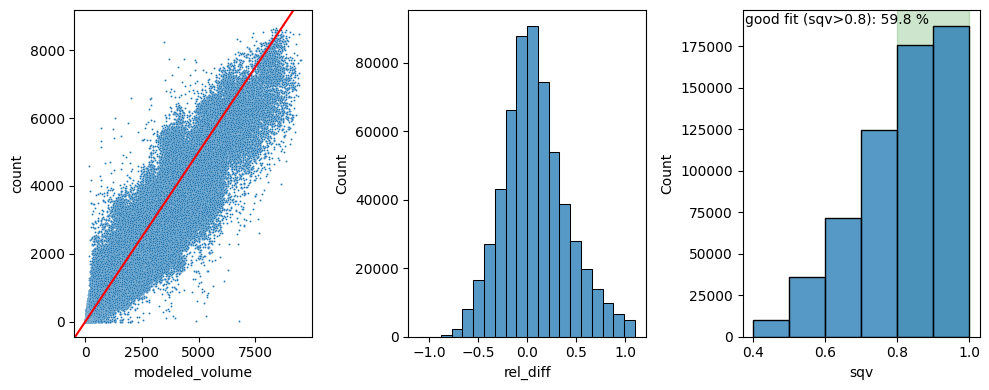

In [54]:
fig, ax = plt.subplots(1,3, figsize = (10,4), tight_layout = True)

mean_diff = all_data['rel_diff'].mean()
std_diff = all_data['rel_diff'].std()

sns.scatterplot(ax = ax[0], x = all_data['modeled_volume'], y = all_data['count'], s= 2)
sns.histplot(ax = ax[1], x = all_data['rel_diff'], binrange=(-1.1, 1.1), bins = 20)
sns.histplot(ax = ax[2], x = all_data['sqv'], binrange=(0.4,1), bins = 6)

text = f'good fit (sqv>0.8): {(len(all_data[all_data["sqv"]>=0.8]) / len(all_data))*100:.1f} % '
ax[2].text(.01, .99, text, ha='left', va='top', transform=ax[2].transAxes)
ax[2].axvspan(0.8, 1, color = 'g', alpha = 0.2, zorder =0)

ax[0].axline([0,0], [1,1], color = 'red')

# Plot Daily Values

In [55]:
daily_count = all_data.groupby('road_link_id').resample('1d')[['count', 'modeled_volume']].sum().reset_index(level=0)
daily_count.drop(daily_count[daily_count['count'] == 0].index, inplace = True)
daily_count['diff'] = daily_count['modeled_volume'] - daily_count['count']
daily_count['rel_diff'] = daily_count['diff'] / daily_count['count']
daily_count['sqv'] = daily_count.apply(lambda x: calc_sqv(x['count'],
                                                    x['modeled_volume'], f= 10000),
                                 axis = 1)

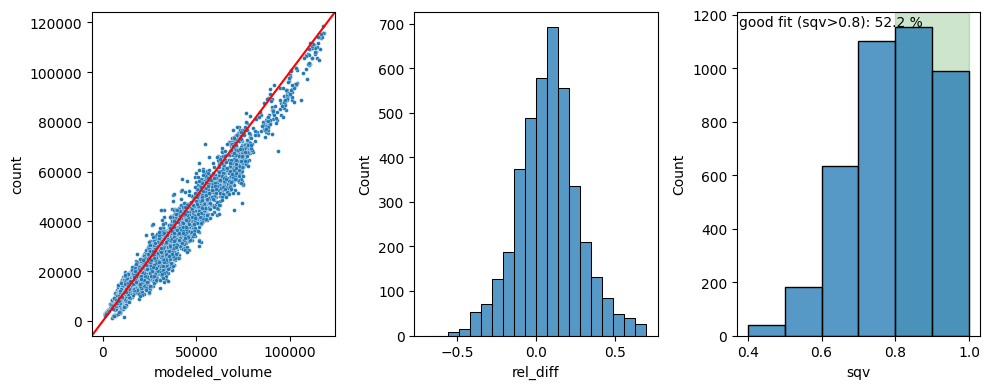

In [56]:
fig, ax = plt.subplots(1,3, figsize = (10,4), tight_layout = True)

mean_diff = all_data['rel_diff'].mean()
std_diff = all_data['rel_diff'].std()

sns.scatterplot(ax = ax[0], x = daily_count['modeled_volume'], y = daily_count['count'], s= 8)
sns.histplot(ax = ax[1], x = daily_count['rel_diff'], binrange=(-0.7, 0.7), bins = 20)
sns.histplot(ax = ax[2], x = daily_count['sqv'], binrange=(0.4,1), bins = 6)

text = f'good fit (sqv>0.8): {(len(daily_count[daily_count["sqv"]>=0.8]) / len(daily_count))*100:.1f} % '
ax[2].text(.01, .99, text, ha='left', va='top', transform=ax[2].transAxes)
ax[2].axvspan(0.8, 1, color = 'g', alpha = 0.2, zorder =0)

ax[0].axline([0,0], [1,1], color = 'red')

# Plot annual values

In [57]:
monthly_count = all_data.groupby('road_link_id').resample('YE')[['count', 'modeled_volume']].sum().reset_index(level=0)
monthly_count.drop(monthly_count[monthly_count['count'] == 0].index, inplace = True)
monthly_count['diff'] = monthly_count['modeled_volume'] - monthly_count['count']
monthly_count['rel_diff'] = monthly_count['diff'] / monthly_count['count']

Text(0.5, 0, 'Relative Difference')

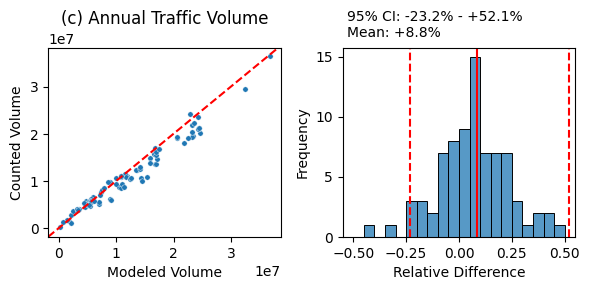

In [58]:
fig, ax = plt.subplots(1,2, figsize = (6,3), tight_layout = True)
ax[0].axline([0,0], [1,1], color = 'red',  linestyle = '--')
sns.scatterplot(ax = ax[0], x = monthly_count['modeled_volume'], y = monthly_count['count'], s= 15)
sns.histplot(ax = ax[1], x = monthly_count['rel_diff'], binrange=(-0.5, 0.5), bins = 20)

lb = np.quantile(monthly_count["rel_diff"].to_numpy(), 0.025)
ub = np.quantile(monthly_count["rel_diff"].to_numpy(), 0.975)
avg = np.mean(monthly_count["rel_diff"].to_numpy())

ax[1].axvline(lb, color = 'r', linestyle = '--')
ax[1].axvline(ub, color = 'r', linestyle = '--')
ax[1].axvline(avg, color = 'r')

text = f'95% CI: {lb*100:.1f}% - +{ub*100:.1f}% \nMean: +{avg*100:.1f}%'
ax[1].text(.02, 1.2, text, ha='left', va='top', transform=ax[1].transAxes)

ax[0].set_title('(c) Annual Traffic Volume')
ax[0].set_xlabel('Modeled Volume')
ax[0].set_ylabel('Counted Volume')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Relative Difference')

## Plot for paper

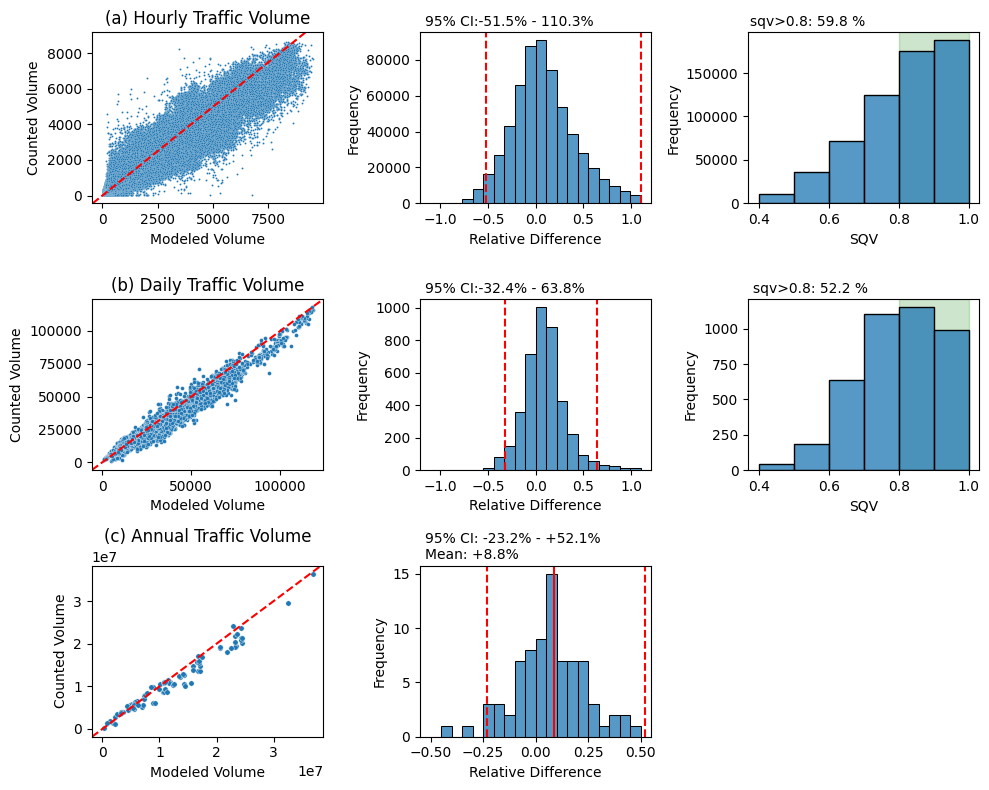

In [59]:
fig, ax = plt.subplots(3,3, figsize = (10,8), tight_layout = True)

ax[2,2].axis('off')

sns.scatterplot(ax = ax[0,0], x = all_data['modeled_volume'], y = all_data['count'], s= 2)
sns.histplot(ax = ax[0,1], x = all_data['rel_diff'], binrange=(-1.1, 1.1), bins = 20)
sns.histplot(ax = ax[0,2], x = all_data['sqv'], binrange=(0.4,1), bins = 6)

lb = np.quantile(all_data["rel_diff"].to_numpy(), 0.025)
ub = np.quantile(all_data["rel_diff"].to_numpy(), 0.975)
ax[0,1].axvline(lb, color = 'r', linestyle = '--')
ax[0,1].axvline(ub, color = 'r', linestyle = '--')
text = f'95% CI:{lb*100:.1f}% - {ub*100:.1f}%'
ax[0,1].text(.02, 1.1, text, ha='left', va='top', transform=ax[0,1].transAxes)

text = f'sqv>0.8: {(len(all_data[all_data["sqv"]>=0.8]) / len(all_data))*100:.1f} % '
ax[0,2].text(.01, 1.1, text, ha='left', va='top', transform=ax[0,2].transAxes)
ax[0,2].axvspan(0.8, 1, color = 'g', alpha = 0.2, zorder =0)

ax[0,0].axline([0,0], [1,1], color = 'red', linestyle = '--')

ax[0,0].set_title('(a) Hourly Traffic Volume')
ax[0,0].set_xlabel('Modeled Volume')
ax[0,0].set_ylabel('Counted Volume')
ax[0,1].set_ylabel('Frequency')
ax[0,2].set_ylabel('Frequency')
ax[0,2].set_xlabel('SQV')
ax[0,1].set_xlabel('Relative Difference')

sns.scatterplot(ax = ax[1,0], x = daily_count['modeled_volume'], y = daily_count['count'], s= 8)
sns.histplot(ax = ax[1,1], x = daily_count['rel_diff'], binrange=(-1.1, 1.1), bins = 20)
sns.histplot(ax = ax[1,2], x = daily_count['sqv'], binrange=(0.4,1), bins = 6)

lb = np.quantile(daily_count["rel_diff"].to_numpy(), 0.025)
ub = np.quantile(daily_count["rel_diff"].to_numpy(), 0.975)
ax[1,1].axvline(lb, color = 'r', linestyle = '--')
ax[1,1].axvline(ub, color = 'r', linestyle = '--')
text = f'95% CI:{lb*100:.1f}% - {ub*100:.1f}%'
ax[1,1].text(.02, 1.1, text, ha='left', va='top', transform=ax[1,1].transAxes)

text = f'sqv>0.8: {(len(daily_count[daily_count["sqv"]>=0.8]) / len(daily_count))*100:.1f} % '
ax[1,2].text(.02, 1.1, text, ha='left', va='top', transform=ax[1,2].transAxes)
ax[1,2].axvspan(0.8, 1, color = 'g', alpha = 0.2, zorder =0)

ax[1,0].axline([0,0], [1,1], color = 'red', linestyle = '--')

ax[1,0].set_title('(b) Daily Traffic Volume')
ax[1,0].set_xlabel('Modeled Volume')
ax[1,0].set_ylabel('Counted Volume')
ax[1,1].set_ylabel('Frequency')
ax[1,2].set_ylabel('Frequency')
ax[1,2].set_xlabel('SQV')
ax[1,1].set_xlabel('Relative Difference')


# add annual estimates to the plot

ax[2,0].axline([0,0], [1,1], color = 'red',  linestyle = '--')
sns.scatterplot(ax = ax[2,0], x = monthly_count['modeled_volume'], y = monthly_count['count'], s= 15)
sns.histplot(ax = ax[2,1], x = monthly_count['rel_diff'], binrange=(-0.5, 0.5), bins = 20)

lb = np.quantile(monthly_count["rel_diff"].to_numpy(), 0.025)
ub = np.quantile(monthly_count["rel_diff"].to_numpy(), 0.975)
avg = np.mean(monthly_count["rel_diff"].to_numpy())

ax[2,1].axvline(lb, color = 'r', linestyle = '--')
ax[2,1].axvline(ub, color = 'r', linestyle = '--')
ax[2,1].axvline(avg, color = 'r')

text = f'95% CI: {lb*100:.1f}% - +{ub*100:.1f}% \nMean: +{avg*100:.1f}%'
ax[2,1].text(.02, 1.2, text, ha='left', va='top', transform=ax[2,1].transAxes)

ax[2,0].set_title('(c) Annual Traffic Volume')
ax[2,0].set_xlabel('Modeled Volume')
ax[2,0].set_ylabel('Counted Volume')
ax[2,1].set_ylabel('Frequency')
ax[2,1].set_xlabel('Relative Difference')
plt.show()


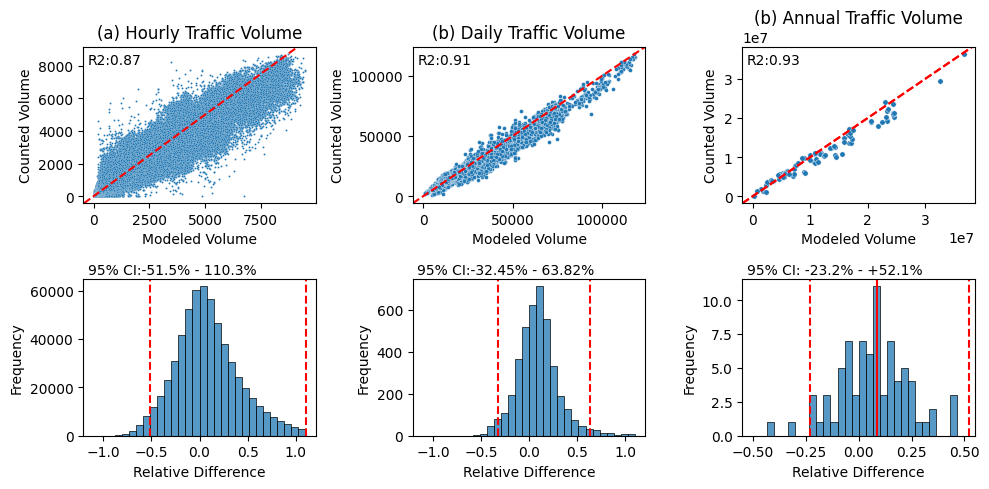

In [60]:
fig, ax = plt.subplots(2,3, figsize = (10,5), tight_layout = True)
plt.ticklabel_format(style = 'plain')

sns.scatterplot(ax = ax[0,0], x = all_data['modeled_volume'], y = all_data['count'], s= 2)
ax[0,0].axline([0,0], [1,1], color = 'red', linestyle = '--')
text = f'R2:{r2_score(all_data["count"], all_data["modeled_volume"]):.2f}'
ax[0,0].text(.02, 0.96, text, ha='left', va='top', transform=ax[0,0].transAxes)

sns.histplot(ax = ax[1,0], x = all_data['rel_diff'], binrange=(-1.1, 1.1), bins = 30)
lb = np.quantile(all_data["rel_diff"].to_numpy(), 0.025)
ub = np.quantile(all_data["rel_diff"].to_numpy(), 0.975)
ax[1,0].axvline(lb, color = 'r', linestyle = '--')
ax[1,0].axvline(ub, color = 'r', linestyle = '--')

text = f'95% CI:{lb*100:.1f}% - {ub*100:.1f}%'
ax[1,0].text(.02, 1.1, text, ha='left', va='top', transform=ax[1,0].transAxes)

ax[0,0].set_title('(a) Hourly Traffic Volume')
ax[0,0].set_xlabel('Modeled Volume')
ax[0,0].set_ylabel('Counted Volume')
ax[1,0].set_ylabel('Frequency')
ax[1,0].set_xlabel('Relative Difference')
ax[0,0].ticklabel_format(style = 'scientific')

### daily data

sns.scatterplot(ax = ax[0,1], x = daily_count['modeled_volume'], y = daily_count['count'], s= 8)
ax[0,1].axline([0,0], [1,1], color = 'red', linestyle = '--')
text = f'R2:{r2_score(daily_count["count"], daily_count["modeled_volume"]):.2f}'
ax[0,1].text(.02, 0.96, text, ha='left', va='top', transform=ax[0,1].transAxes)

sns.histplot(ax = ax[1,1], x = daily_count['rel_diff'], binrange=(-1.1, 1.1), bins = 30)

lb = np.quantile(daily_count["rel_diff"].to_numpy(), 0.025)
ub = np.quantile(daily_count["rel_diff"].to_numpy(), 0.975)
ax[1,1].axvline(lb, color = 'r', linestyle = '--')
ax[1,1].axvline(ub, color = 'r', linestyle = '--')
text = f'95% CI:{lb*100:.2f}% - {ub*100:.2f}%'
ax[1,1].text(.02, 1.1, text, ha='left', va='top', transform=ax[1,1].transAxes)

ax[0,1].set_title('(b) Daily Traffic Volume')
ax[0,1].set_xlabel('Modeled Volume')
ax[0,1].set_ylabel('Counted Volume')
ax[1,1].set_ylabel('Frequency')
ax[1,1].set_xlabel('Relative Difference')
ax[0,1].ticklabel_format(style = 'scientific')

# add annual estimates to the plot
sns.scatterplot(ax = ax[0,2], x = monthly_count['modeled_volume'], y = monthly_count['count'], s= 15)
ax[0,2].axline([0,0], [1,1], color = 'red',  linestyle = '--')
ax[0,2].axline([0,0], [1,1], color = 'red', linestyle = '--')
text = f'R2:{r2_score(monthly_count["count"], monthly_count["modeled_volume"]):.2f}'
ax[0,2].text(.02, 0.96, text, ha='left', va='top', transform=ax[0,2].transAxes)

sns.histplot(ax = ax[1,2], x = monthly_count['rel_diff'], binrange=(-0.5, 0.5), bins = 30)

lb = np.quantile(monthly_count["rel_diff"].to_numpy(), 0.025)
ub = np.quantile(monthly_count["rel_diff"].to_numpy(), 0.975)
avg = np.mean(monthly_count["rel_diff"].to_numpy())

ax[1,2].axvline(lb, color = 'r', linestyle = '--')
ax[1,2].axvline(ub, color = 'r', linestyle = '--')
ax[1,2].axvline(avg, color = 'r')

text = f'95% CI: {lb*100:.1f}% - +{ub*100:.1f}%'
ax[1,2].text(.02, 1.1, text, ha='left', va='top', transform=ax[1,2].transAxes)

ax[0,2].set_title('(b) Annual Traffic Volume')
ax[0,2].set_xlabel('Modeled Volume')
ax[0,2].set_ylabel('Counted Volume')
ax[1,2].set_ylabel('Frequency')
ax[1,2].set_xlabel('Relative Difference')
ax[0,2].ticklabel_format(style = 'scientific')
plt.show()


# Colorize by road type

In [61]:
# add road link information to 'all data'


In [ ]:
all_data = all_data.merge(traffic_model.reset_index()[['road_link_id', 'road_type']],
                          left_on='road_link_id', right_on='road_link_id', how='left')


,count,modeled_volume,road_link_id,diff,rel_diff,sqv,road_type
0,543.0,431.464469,3.800000e+01,-111.535531,-0.205406,0.868537,TrunkRoad/Primary-City
1,433.0,253.648809,3.800000e+01,-179.351191,-0.414206,0.785818,TrunkRoad/Primary-City
2,332.0,172.585788,3.800000e+01,-159.414212,-0.480163,0.783289,TrunkRoad/Primary-City
3,320.0,175.200724,3.800000e+01,-144.799276,-0.452498,0.796196,TrunkRoad/Primary-City
4,492.0,313.792341,3.800000e+01,-178.207659,-0.362211,0.797407,TrunkRoad/Primary-City
...,...,...,...,...,...,...,...
607054,978.0,1063.766993,2.147483e+09,85.766993,0.087696,0.920195,Distributor/Secondary
607055,827.0,794.357233,2.147483e+09,-32.642767,-0.039471,0.965349,Distributor/Secondary
607056,564.0,630.082989,2.147483e+09,66.082989,0.117168,0.919123,Distributor/Secondary
607057,483.0,559.992645,2.147483e+09,76.992645,0.159405,0.900265,Distributor/Secondary


In [ ]:
daily_count = daily_count.merge(traffic_model.reset_index()[['road_link_id', 'road_type']],
                          left_on='road_link_id', right_on='road_link_id', how='left')

monthly_count = monthly_count.merge(traffic_model.reset_index()[['road_link_id', 'road_type']],
                          left_on='road_link_id', right_on='road_link_id', how='left')


In [74]:
colors = dict(zip(all_data['road_type'].unique(), sns.color_palette('colorblind')))

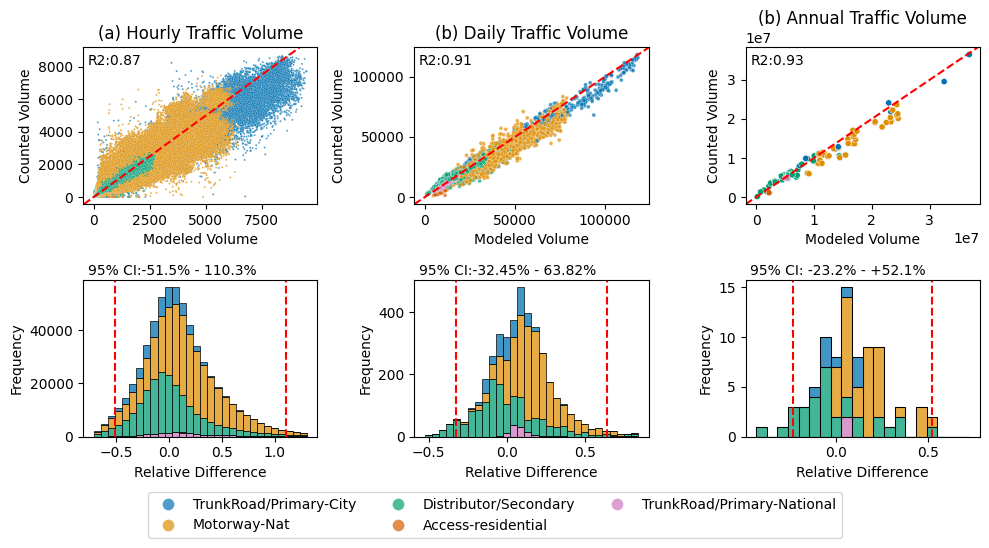

In [100]:
fig, ax = plt.subplots(2,3, figsize = (10,5), tight_layout = True)
plt.ticklabel_format(style = 'plain')

_data = all_data
lb = np.quantile(_data["rel_diff"].to_numpy(), 0.025)
ub = np.quantile(_data["rel_diff"].to_numpy(), 0.975)
scatter_ax = ax[0,0]
hist_ax = ax[1,0]

sns.scatterplot(data = _data, ax = scatter_ax,
                x = 'modeled_volume', y = 'count', hue='road_type',
                s= 2, palette = colors, alpha = 0.7)
scatter_ax.axline([0,0], [1,1], color = 'red', linestyle = '--')
text = f'R2:{r2_score(_data["count"], _data["modeled_volume"]):.2f}'
scatter_ax.text(.02, 0.96, text, ha='left', va='top', transform=scatter_ax.transAxes)
scatter_ax.legend_.remove()

sns.histplot(data = _data, x = 'rel_diff', hue ='road_type',
             multiple='stack', palette = colors,
            ax = hist_ax, binrange=(lb-0.2, ub+0.2), bins = 30)

hist_ax.legend_.remove()
hist_ax.axvline(lb, color = 'r', linestyle = '--')
hist_ax.axvline(ub, color = 'r', linestyle = '--')

text = f'95% CI:{lb*100:.1f}% - {ub*100:.1f}%'
hist_ax.text(.02, 1.1, text, ha='left', va='top', transform=hist_ax.transAxes)

scatter_ax.set_title('(a) Hourly Traffic Volume')
scatter_ax.set_xlabel('Modeled Volume')
scatter_ax.set_ylabel('Counted Volume')
hist_ax.set_ylabel('Frequency')
hist_ax.set_xlabel('Relative Difference')
scatter_ax.ticklabel_format(style = 'scientific')

### daily data

_data = daily_count
lb = np.quantile(_data["rel_diff"].to_numpy(), 0.025)
ub = np.quantile(_data["rel_diff"].to_numpy(), 0.975)
scatter_ax = ax[0,1]
hist_ax = ax[1,1]

sns.scatterplot(data = _data, ax = scatter_ax,
                x = 'modeled_volume', y = 'count', hue='road_type',
                s= 8, palette = colors, alpha = 0.7)
scatter_ax.axline([0,0], [1,1], color = 'red', linestyle = '--')
text = f'R2:{r2_score(_data["count"], _data["modeled_volume"]):.2f}'
scatter_ax.text(.02, 0.96, text, ha='left', va='top', transform=scatter_ax.transAxes)
scatter_ax.legend_.remove()

sns.histplot(data = _data, x = 'rel_diff', hue ='road_type',
             multiple='stack', palette = colors,
            ax = hist_ax, binrange=(lb-0.2, ub+0.2), bins = 30)
hist_ax.legend_.remove()
hist_ax.axvline(lb, color = 'r', linestyle = '--')
hist_ax.axvline(ub, color = 'r', linestyle = '--')
text = f'95% CI:{lb*100:.2f}% - {ub*100:.2f}%'
hist_ax.text(.02, 1.1, text, ha='left', va='top', transform=hist_ax.transAxes)

scatter_ax.set_title('(b) Daily Traffic Volume')
scatter_ax.set_xlabel('Modeled Volume')
scatter_ax.set_ylabel('Counted Volume')
hist_ax.set_ylabel('Frequency')
hist_ax.set_xlabel('Relative Difference')
scatter_ax.ticklabel_format(style = 'scientific')



# add annual estimates to the plot
_data = monthly_count
lb = np.quantile(_data["rel_diff"].to_numpy(), 0.025)
ub = np.quantile(_data["rel_diff"].to_numpy(), 0.975)
scatter_ax = ax[0,2]
hist_ax = ax[1,2]

sns.scatterplot(data = _data, ax = scatter_ax,
                x = 'modeled_volume', y = 'count', hue='road_type',
                s= 20, palette = colors, alpha = 1)
scatter_ax.axline([0,0], [1,1], color = 'red', linestyle = '--')
text = f'R2:{r2_score(_data["count"], _data["modeled_volume"]):.2f}'
scatter_ax.text(.02, 0.96, text, ha='left', va='top', transform=scatter_ax.transAxes)
scatter_ax.legend_.remove()

sns.histplot(data = _data, ax = hist_ax, x = 'rel_diff', hue ='road_type',
             multiple='stack', palette = colors, binrange=(lb-0.2, ub+0.2), bins = 20)
hist_ax.legend_.remove()
hist_ax.axvline(lb, color = 'r', linestyle = '--')
hist_ax.axvline(ub, color = 'r', linestyle = '--')

text = f'95% CI: {lb*100:.1f}% - +{ub*100:.1f}%'
hist_ax.text(.02, 1.1, text, ha='left', va='top', transform=hist_ax.transAxes)

scatter_ax.set_title('(b) Annual Traffic Volume')
scatter_ax.set_xlabel('Modeled Volume')
scatter_ax.set_ylabel('Counted Volume')
hist_ax.set_ylabel('Frequency')
hist_ax.set_xlabel('Relative Difference')
scatter_ax.ticklabel_format(style = 'scientific')

# add legend
# combined legend for all scatterplots
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), markerscale = 6, ncols = 3)

plt.show()
